In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import xarray as xr

In [2]:
data_xr = xr.open_dataset('state.0000000000.t001.nc')
data_xr
# important: dimensions are
# (batch_size, channels, height, width)

<xarray.Dataset>
Dimensions:  (T: 11, X: 11, Xp1: 12, Y: 78, Yp1: 79, Z: 42, Zl: 42)
Coordinates:
  * T        (T) float64 0.0 3.11e+07 6.221e+07 ... 2.488e+08 2.799e+08 3.11e+08
  * Xp1      (Xp1) float64 0.0 2.0 4.0 6.0 8.0 10.0 ... 14.0 16.0 18.0 20.0 22.0
  * Y        (Y) float64 -59.5 -58.48 -57.44 -56.36 ... 58.48 59.5 60.5 61.5
  * Z        (Z) float64 -5.0 -15.05 -25.25 ... -4.375e+03 -4.625e+03 -4.875e+03
  * X        (X) float64 1.0 3.0 5.0 7.0 9.0 11.0 13.0 15.0 17.0 19.0 21.0
  * Yp1      (Yp1) float64 -60.0 -59.0 -57.97 -56.91 ... 59.0 60.0 61.0 62.0
  * Zl       (Zl) float64 0.0 -10.0 -20.1 -30.4 ... -4.25e+03 -4.5e+03 -4.75e+03
Data variables:
    iter     (T) int32 ...
    U        (T, Z, Y, Xp1) float32 ...
    V        (T, Z, Yp1, X) float32 ...
    Temp     (T, Z, Y, X) float32 ...
    S        (T, Z, Y, X) float32 ...
    Eta      (T, Y, X) float32 ...
    W        (T, Zl, Y, X) float32 ...
Attributes:
    the_run_name:    2deg
    MITgcm_version:  checkpoint67f
   

In [103]:
data = torch.FloatTensor(data_xr['Temp'].values)[:,2:,:-4,:-2] # filtering out land?

In [104]:
torch.numel(data), data.shape

(293040, torch.Size([11, 40, 74, 9]))

In [105]:
down = nn.Sequential(
    nn.Conv2d(in_channels=data.shape[1], out_channels=32, kernel_size=(5, 3)),
#     nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(32, 16, (5, 2)),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 8, (5, 2), stride=(1,1)))

In [106]:
print(data.shape, "->", down(data).shape)

torch.Size([11, 40, 74, 9]) -> torch.Size([11, 8, 29, 2])


In [107]:
sum([torch.numel(a) for a in down.parameters()])


25656

In [108]:
z = down(data)

In [109]:
up = nn.Sequential(
    nn.ConvTranspose2d(8, 16, (5,2), stride=(1,1)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(16, 32, (5, 2)),
    nn.ReLU(),
    nn.ConvTranspose2d(32, data.shape[1], (5, 3)))

up(z).shape

torch.Size([11, 40, 74, 9])

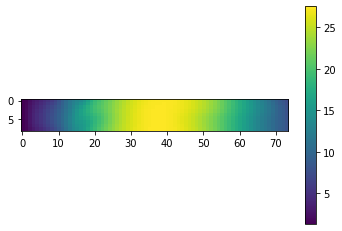

In [110]:
plt.imshow(data[0][0].T);
plt.colorbar();

In [111]:
def transform(X):
    return (2.0 + X).log() - 2.0

def inverse_transform(X):
    return (X + 2.0).exp() - 2.0

LAND = ((data == 0).float().mean(0) == 1.0)

In [112]:
X_t = transform(data)

joint_model = nn.Sequential(down, up)
losses = []
opt = torch.optim.Adam(joint_model.parameters())

In [113]:
sum([torch.numel(p) for p in joint_model.parameters()])

51344

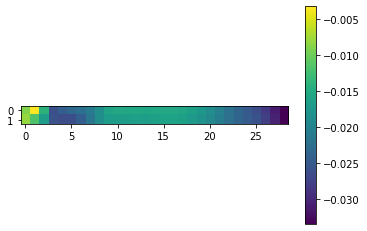

In [114]:
with torch.no_grad():
    plt.imshow(down(X_t)[0][0].T);
    plt.colorbar();

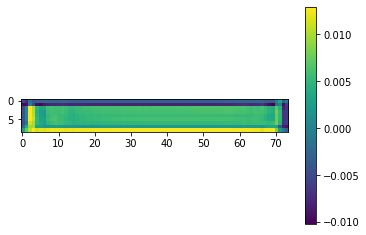

In [115]:
with torch.no_grad():
    plt.imshow(joint_model(X_t)[0][0].T);
    plt.colorbar();

In [128]:

for _ in range(100):
    opt.zero_grad()
    loss = (joint_model(X_t[:-1]) - X_t[1:]).pow(2).mean()
    loss.backward()
    opt.step()
    losses.append(loss.item())


In [129]:
losses[-1]

0.0008864242699928582

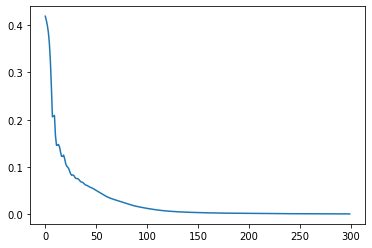

In [130]:
plt.plot(losses)

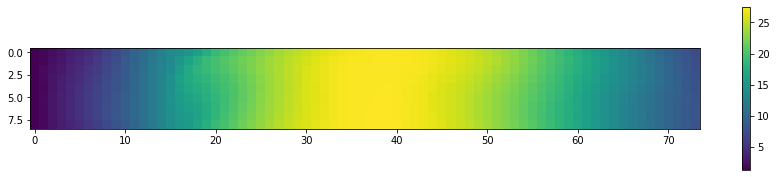

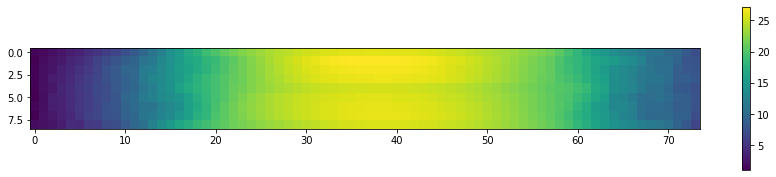

In [135]:
ix = 0
depth = 0

plt.figure(figsize=(15,3))
plt.imshow(data[ix+1,depth].T)
plt.colorbar();

plt.figure(figsize=(15,3))
with torch.no_grad():
    pred = inverse_transform(joint_model(X_t)[ix][depth].T)
    pred[LAND[depth].T] = 0.0
    plt.imshow(pred);
    plt.colorbar();

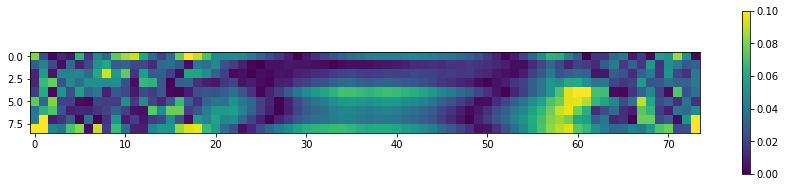

In [136]:
plt.figure(figsize=(15,3))
with torch.no_grad():
    residual = joint_model(X_t)[ix][depth].T - X_t[ix+1][depth].T
    residual[LAND[depth].T] = 0.0
    plt.imshow(residual.abs(), vmin=0, vmax=0.1);
    plt.colorbar();

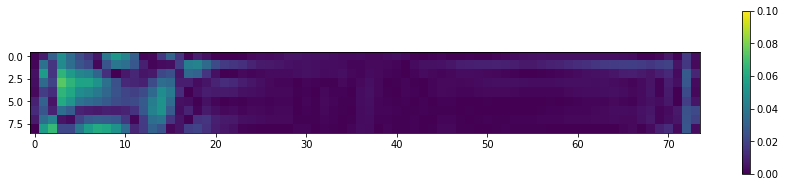

In [137]:
plt.figure(figsize=(15,3))
with torch.no_grad():
    residual = X_t[ix][depth].T - X_t[ix+1][depth].T
    plt.imshow(residual.abs(), vmin=0, vmax=.1);
    plt.colorbar();